# File Info

Training for functions for neural odes and augemented neural odes.

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

# Data Generation



In [28]:
lc = ds.Hopf(rho=1.0, alpha=-1.0, beta=0.0)

In [83]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b)  #traj, dim


t_span = (0, 13); dt = 0.05
ic.shape #traj, dim

sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )

In [89]:
sol.shape

torch.Size([260, 64, 3])

In [90]:
time = torch.arange(t_span[0], t_span[1], dt).unsqueeze(1).unsqueeze(2)  #(time, 1, 1)
time.shape

torch.Size([260, 1, 1])

In [91]:
time_expanded = time.repeat(1, ic.shape[0], 1)  #(time, traj, 1)
time_expanded.shape

torch.Size([260, 64, 1])

In [92]:
sol2 = torch.cat((sol, time_expanded), dim=-1)  #(time, traj, dim+1)
sol.shape

torch.Size([260, 64, 3])

In [93]:
data_tensor = torch.stack((sol[0:-4, :, :], sol[4:, :, :]), dim=1)
data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=64, shuffle=True)

# Model 

In [107]:
model = nodes.NODE(input_dim=3, output_dim=2, hidden_dim=50, depth=8, activation_func=nn.Tanh(), t_span=(0, 0.05), dt=0.01)

In [108]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()



In [109]:
pred_x = model(t=0, x=data_loader.dataset[:,0,:,:])
loss = loss_fn(pred_x[-1, :, :, :], data_loader.dataset[:,1,:,:2]) 
loss

tensor(2.0909, grad_fn=<MseLossBackward0>)

In [110]:
data_loader.dataset.shape

torch.Size([256, 2, 64, 3])

In [111]:
old_x_batch = x_batch.clone()

In [129]:
num_epochs = 500
for epoch in tqdm(range(num_epochs)):
    for i, (x_batch) in enumerate(data_loader): #(num_pairs, pairs, traj, dim)
        
        optimizer.zero_grad()

        # Predicting the trajectory
        pred_x = model(t=0, x=x_batch[:,0,:,:])

        # Calculating loss
        loss = loss_fn(pred_x[-1, :, :, :], x_batch[:,1,:,:2]) 
        

        # Backpropagation
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        pred_x = model(t=0, x=data_loader.dataset[:,0,:,:])
        loss = loss_fn(pred_x[-1, :, :, :], data_loader.dataset[:,1,:,:2]) 
        loss_list.append(loss.item())

  0%|          | 1/500 [00:00<07:45,  1.07it/s]

Epoch 0, Loss: 0.0003644085954874754


  4%|▍         | 20/500 [00:21<10:00,  1.25s/it]

Epoch 20, Loss: 0.0002821871021296829


  8%|▊         | 40/500 [00:46<09:21,  1.22s/it]

Epoch 40, Loss: 0.00021118145377840847


 12%|█▏        | 60/500 [01:10<08:46,  1.20s/it]

Epoch 60, Loss: 5.116801185067743e-05


 16%|█▌        | 80/500 [01:34<08:00,  1.14s/it]

Epoch 80, Loss: 0.00023390731075778604


 20%|██        | 100/500 [01:58<07:54,  1.19s/it]

Epoch 100, Loss: 3.371905768290162e-05


 24%|██▍       | 120/500 [02:23<07:28,  1.18s/it]

Epoch 120, Loss: 2.154594039893709e-05


 28%|██▊       | 140/500 [02:47<07:08,  1.19s/it]

Epoch 140, Loss: 1.818115015339572e-05


 32%|███▏      | 160/500 [03:09<04:47,  1.18it/s]

Epoch 160, Loss: 0.0002921618870459497


 36%|███▌      | 180/500 [03:26<04:30,  1.18it/s]

Epoch 180, Loss: 1.0417643352411687e-05


 40%|████      | 200/500 [03:41<03:53,  1.29it/s]

Epoch 200, Loss: 1.3397197108133696e-05


 44%|████▍     | 220/500 [03:57<03:29,  1.34it/s]

Epoch 220, Loss: 2.1363175619626418e-05


 48%|████▊     | 240/500 [04:12<03:12,  1.35it/s]

Epoch 240, Loss: 1.3050282177573536e-05


 52%|█████▏    | 260/500 [04:28<03:07,  1.28it/s]

Epoch 260, Loss: 2.0688790755230002e-05


 56%|█████▌    | 280/500 [04:43<02:50,  1.29it/s]

Epoch 280, Loss: 0.00019215972861275077


 60%|██████    | 300/500 [04:59<02:36,  1.27it/s]

Epoch 300, Loss: 1.0947660484816879e-05


 64%|██████▍   | 320/500 [05:15<02:21,  1.27it/s]

Epoch 320, Loss: 1.0514259884075727e-05


 68%|██████▊   | 340/500 [05:31<02:03,  1.30it/s]

Epoch 340, Loss: 6.099990969232749e-06


 72%|███████▏  | 360/500 [05:47<01:50,  1.26it/s]

Epoch 360, Loss: 7.753234240226448e-05


 76%|███████▌  | 380/500 [06:02<01:33,  1.28it/s]

Epoch 380, Loss: 5.609985237242654e-06


 80%|████████  | 400/500 [06:18<01:13,  1.36it/s]

Epoch 400, Loss: 6.320771717582829e-06


 84%|████████▍ | 420/500 [06:33<01:00,  1.31it/s]

Epoch 420, Loss: 1.863784564193338e-05


 88%|████████▊ | 440/500 [06:49<00:45,  1.31it/s]

Epoch 440, Loss: 4.026213719043881e-05


 92%|█████████▏| 460/500 [07:04<00:31,  1.28it/s]

Epoch 460, Loss: 4.499335409491323e-05


 96%|█████████▌| 480/500 [07:20<00:15,  1.31it/s]

Epoch 480, Loss: 1.1802585504483432e-05


100%|██████████| 500/500 [07:36<00:00,  1.09it/s]


Text(0.5, 0, 'Epochs')

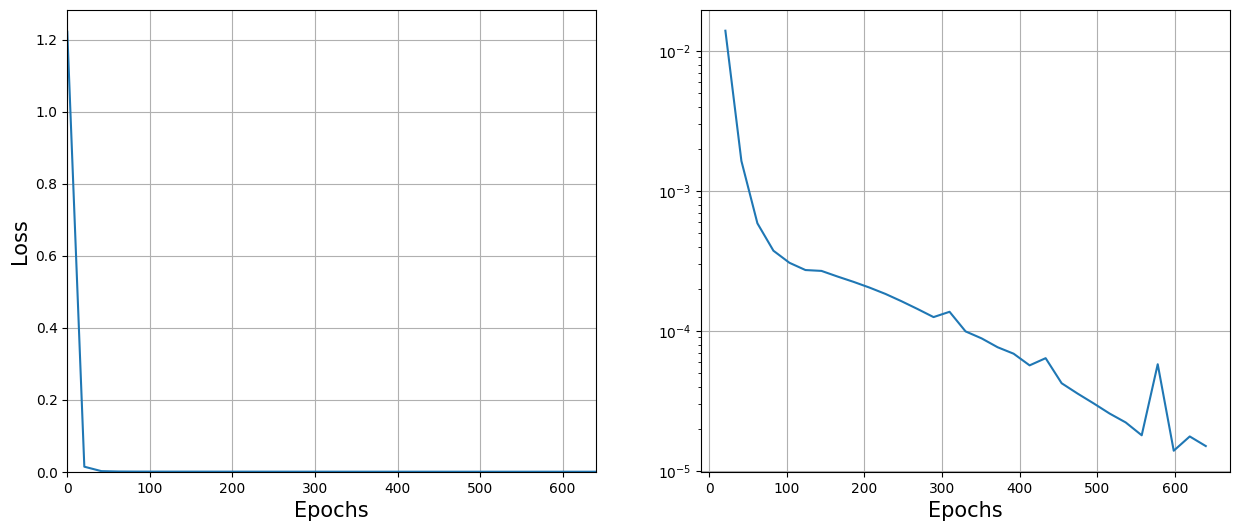

In [130]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs*20, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs*20)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs*20, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [131]:
pred_x = model(t=0, x=data_loader.dataset[:,0,:,:])
loss = loss_fn(pred_x[-1, :, :, :], data_loader.dataset[:,1,:,:2]) 
print(f'Final Loss: {loss.item()}')

Final Loss: 1.1729245670721866e-05


# Analyzing the trained model

In [132]:
def trained_f(t, x):
    t_tensor = torch.tensor([t]).expand(x.shape[0], 1)
    input = torch.cat((x, t_tensor), dim=-1)

    z = model.input_layer(input)

    out = model.f(t, z)
    return model.output_layer(out)

## Data Generation with trained NODE

In [137]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b)  # (num_pts, dim)

t_Start_pred = 0; t_Final_pred = 5; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)

node_data = odeint(trained_f, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})


node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(100, 100, 2)
(100, 100, 2)


## Plotting phase space

Text(0, 0.5, 'X')

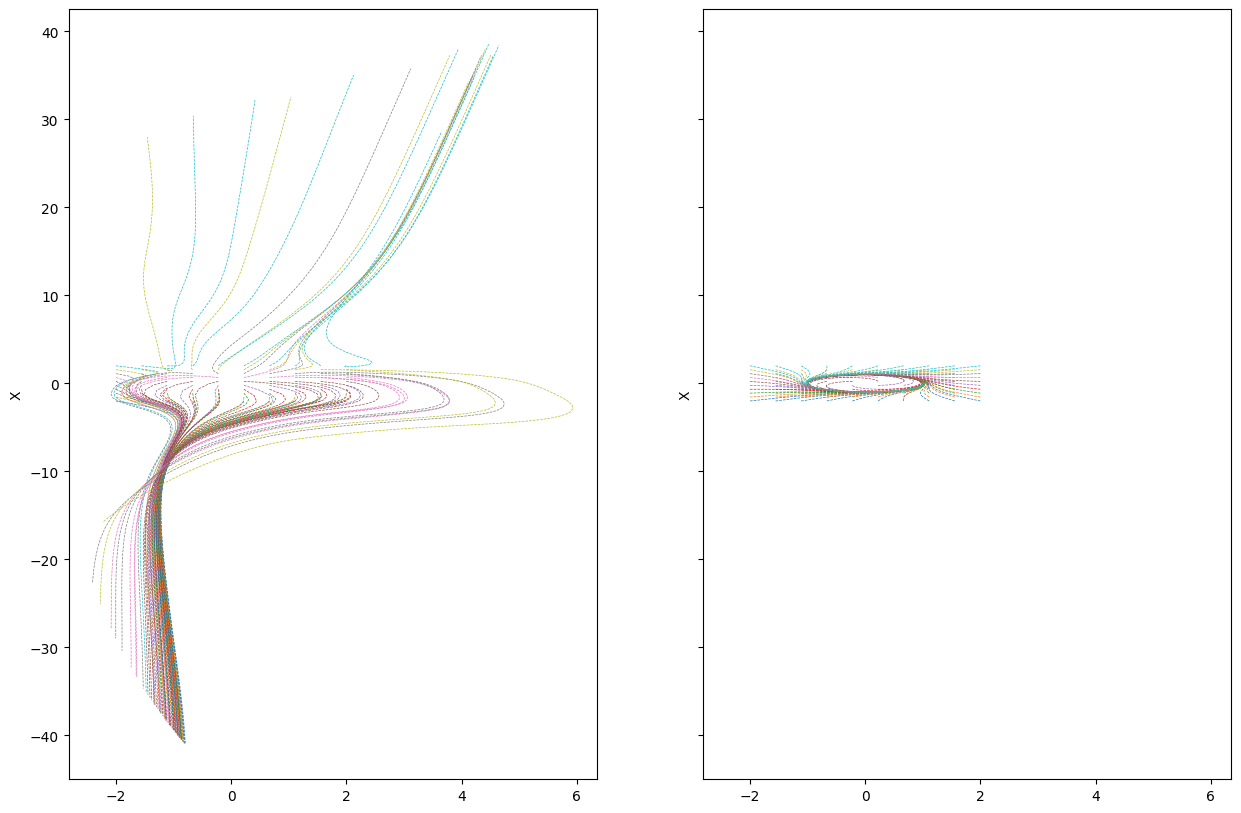

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].plot(node_data[:, :, 0],
                node_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_ylabel('X')


axes[1].plot(true_data[:, :, 0],
                true_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].set_ylabel('X')

In [ ]:
# 2D heatmap of a scalar derived from model.f at t=0
import torch
import matplotlib.pyplot as plt

# grid
x_min, x_max, y_min, y_max = -2.0, 2.0, -2.0, 2.0
n = 200
xs = torch.linspace(x_min, x_max, n)
ys = torch.linspace(y_min, y_max, n)
X, Y = torch.meshgrid(xs, ys, indexing="ij")

# stack into (N, 2)
pts = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)

# add time column to match model input_dim=3
t_col = torch.zeros((pts.shape[0], 1), dtype=pts.dtype, device=pts.device)
inputs = torch.cat([pts, t_col], dim=1)  # (N, 3)

# evaluate model.f at t=0 (model.f expects hidden-dim input)
with torch.no_grad():
    z = model.input_layer(inputs)
    f = model.f(t=0, x=z)  # shape (N, hidden_dim)
    mag = torch.linalg.norm(f, dim=1).reshape(n, n)

# plot
plt.figure(figsize=(6,5))
plt.pcolormesh(X.numpy(), Y.numpy(), mag.numpy(), shading="auto")
plt.colorbar(label="||f||")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heatmap of ||f(t=0, x, y)||")
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40000x2 and 3x50)

In [139]:
x_min, x_max, y_min, y_max = -2.0, 2.0, -2.0, 2.0
n = 200
xs = torch.linspace(x_min, x_max, n)
ys = torch.linspace(y_min, y_max, n)
X, Y = torch.meshgrid(xs, ys, indexing="ij")

# stack into (N, 2)
pts = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)

# evaluate model.f at t=0
with torch.no_grad():
    f = model.f(t=0, x=pts)  # shape (N, d)
    mag = torch.linalg.norm(f, dim=1).reshape(n, n)

# plot
plt.figure(figsize=(6,5))
plt.pcolormesh(X.numpy(), Y.numpy(), mag.numpy(), shading="auto")
plt.colorbar(label="||f||")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heatmap of ||f(t=0, x, y)||")
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40000x2 and 50x50)

In [ ]:
# Plotting time traces: 

In [63]:
traj = 50
t = t_eval_pred.detach().numpy()
x = node_data[:, traj, :]
x_true = true_data[:, traj, :]



In [64]:
def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates to polar coordinates.
    
    Parameters:
    x, y: float or array-like
        Cartesian coordinates
    
    Returns:
    r: float or array
        Radius (distance from origin)
    theta: float or array
        Angle in radians (from positive x-axis)
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    
    Parameters:
    r: float or array-like
        Radius (distance from origin)
    theta: float or array-like
        Angle in radians (from positive x-axis)
    
    Returns:
    x, y: float or array
        Cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [65]:

r, theta = cartesian_to_polar(x[:, 0], x[:, 1])
r_true, theta_true = cartesian_to_polar(x_true[:, 0], x_true[:, 1])

C:\Users\jackr\AppData\Local\Temp\ipykernel_32408\3089097437.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


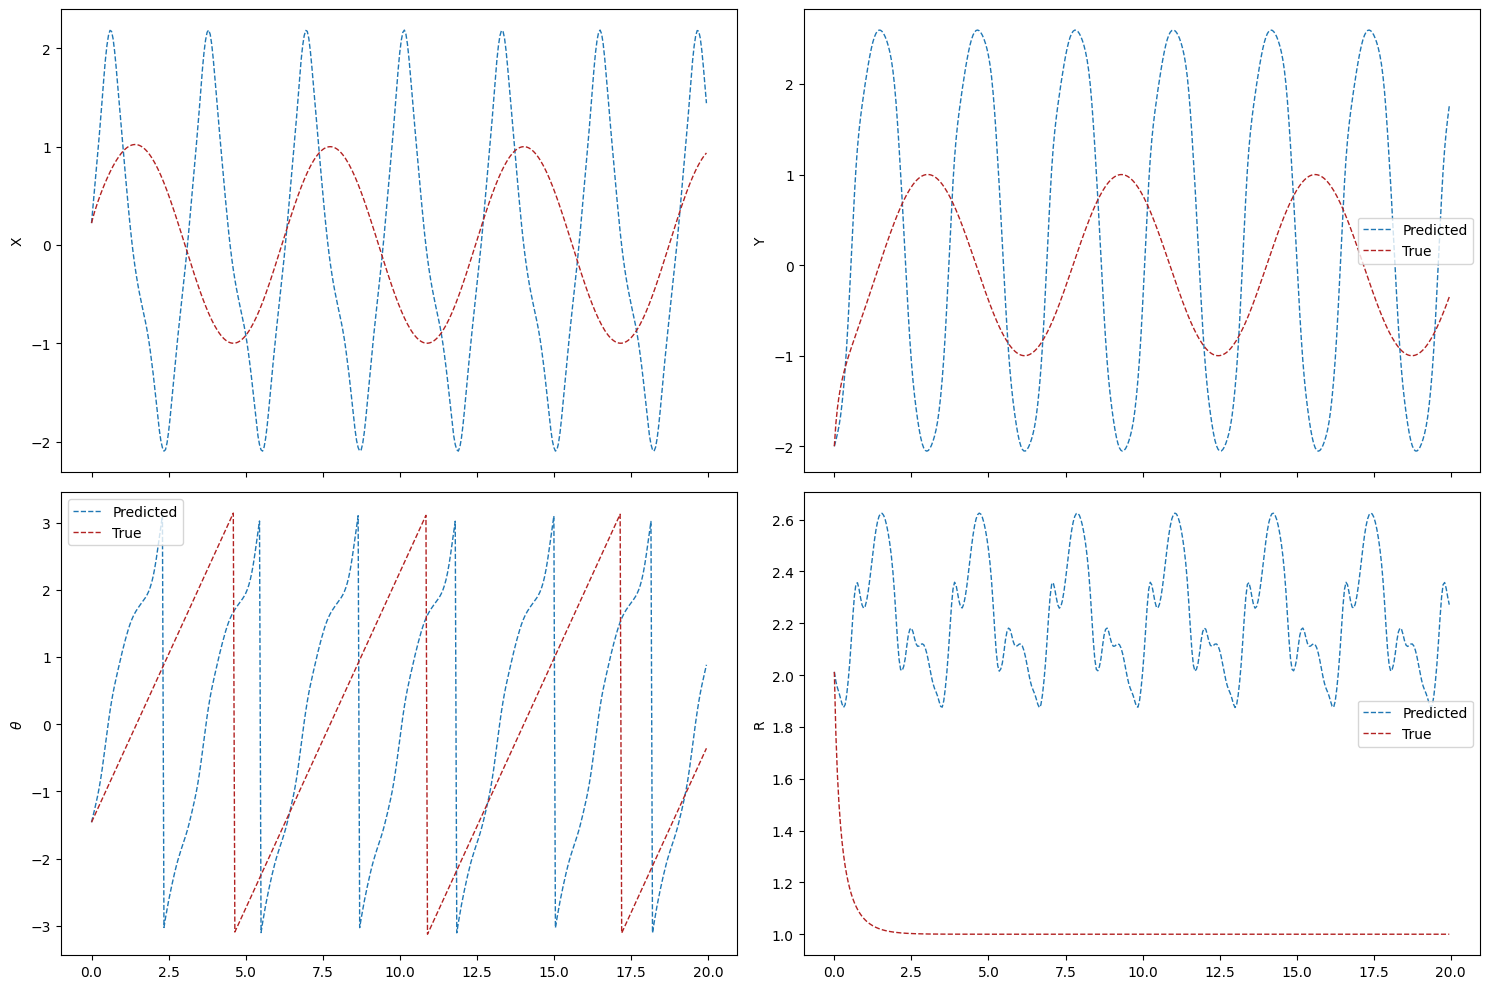

In [67]:


fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)


axes[0, 0].plot(t,
                x[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 0].plot(t, x_true[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 0].set_ylabel('X')

axes[0, 1].legend()


axes[0, 1].plot(t,
                x[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 1].plot(t, x_true[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()

axes[1, 1].plot(t,
                r,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 1].plot(t, r_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 1].set_ylabel('R')
axes[1, 1].legend()


axes[1, 0].plot(t,
                theta,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 0].plot(t, theta_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 0].set_ylabel(r'$\theta$')
axes[1, 0].legend()
plt.tight_layout()
plt.show()